In [1]:
import time
notebook_start_time = time.time()

# An LLM Architecture (Backbone)

Let's set the configuration:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## A Placeholder GPT2 Model Architecture Class

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,
               config
               ):
    super().__init__()
    self.token_emb = nn.Embedding(config["vocab_size"],
                                  config["emb_dim"])
    self.position_emb = nn.Embedding(config["context_length"],
                                     config["emb_dim"])
    self.drop_emb = nn.Dropout(config["drop_rate"])

    # a placeholder for TransformerBlock
    self.transformer_blocks = nn.Sequential(
        *[DummyTransformerBlock(config) for _ in range(config["n_layers"])])

    # a placeholder for LayerNorm
    self.final_norm = DummyLayerNorm(config["emb_dim"])

    self.out_head = nn.Linear(config["emb_dim"],
                              config["vocab_size"],
                              bias=False)

  def forward(self, input_token):
    batch_size, sequence_length = input_token.shape
    token_embeds = self.token_emb(input_token)
    position_embeds = self.position_emb(
        torch.arange(sequence_length,
                     device=input_token.device))
    embeds = token_embeds + position_embeds
    x = self.drop_emb(embeds)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


# placeholder
class DummyTransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

  def forward(self, x):
    return x


# placeholder
class DummyLayerNorm(nn.Module):
  def __init__(self, config):
    super().__init__()

  def forward(self, x):
    return x

In [4]:
# setup example
import tiktoken

bpe_tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(bpe_tokenizer.encode(txt1)))
batch.append(torch.tensor(bpe_tokenizer.encode(txt2)))
batch = torch.stack(batch)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [5]:
# create an instance
torch.manual_seed(211)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("output shape: ", logits.shape)
logits

output shape:  torch.Size([2, 4, 50257])


tensor([[[-0.8344, -1.1415,  0.6781,  ...,  0.5266,  0.7607,  0.9310],
         [ 0.0128,  0.4333, -0.4135,  ...,  0.5391,  0.0836,  0.6025],
         [ 0.4171,  0.3006, -0.4873,  ..., -1.8629,  0.1682, -0.8876],
         [ 1.0438, -0.5067,  0.0866,  ..., -0.6608, -0.5339,  1.9094]],

        [[-1.2385, -1.3217,  0.4691,  ...,  0.2034,  0.8297,  0.8731],
         [-0.2632, -0.0216, -0.5709,  ..., -0.4456,  0.6116,  0.5455],
         [ 0.6241, -0.0704, -0.0456,  ..., -1.5775,  0.3410, -0.7189],
         [ 0.1235,  0.4273, -1.2483,  ..., -1.3417, -1.4207,  2.0975]]],
       grad_fn=<UnsafeViewBackward0>)

# Implement LayerNorm

Let's experiment:

In [6]:
# example setup
torch.manual_seed(211)

# create 3 training examples with 5 dimensions each
batch_example = torch.randn(3, 5)

layer = nn.Sequential(nn.Linear(5, 7),
                      nn.ReLU())

output = layer(batch_example)
output

tensor([[1.0540, 0.2893, 0.0442, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8197, 0.1849, 0.1102, 1.7938, 0.3290, 1.2042, 0.0000],
        [0.3081, 0.1382, 0.2541, 0.0000, 0.5109, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
# compute mean and variance of each sample
mean = output.mean(dim=-1, keepdim=True)
var = output.var(dim=-1, keepdim=True)
print("mean: ", mean)
print("variance: ", var)

mean:  tensor([[0.1982],
        [0.6345],
        [0.1730]], grad_fn=<MeanBackward1>)
variance:  tensor([[0.1536],
        [0.4460],
        [0.0383]], grad_fn=<VarBackward0>)


Let's normalize (aka layer normalization) the output:

In [8]:
norm_output = (output - mean) / torch.sqrt(var)
norm_mean = norm_output.mean(dim=-1, keepdim=True)
norm_var = norm_output.var(dim=-1, keepdim=True)

torch.set_printoptions(sci_mode=False)
print("normalized mean: \n", norm_mean)
print("normalized variance: \n", norm_var)
print("normalized layer output: \n", norm_output)

normalized mean: 
 tensor([[     0.0000],
        [     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
normalized variance: 
 tensor([[1.0000],
        [1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
normalized layer output: 
 tensor([[ 2.1836,  0.2324, -0.3930, -0.5058, -0.5058, -0.5058, -0.5058],
        [ 0.2772, -0.6733, -0.7852,  1.7360, -0.4575,  0.8530, -0.9502],
        [ 0.6897, -0.1777,  0.4139, -0.8838,  1.7256, -0.8838, -0.8838]],
       grad_fn=<DivBackward0>)


## Implement LayerNorm class

In [9]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.epsilon = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1,
                unbiased=False, # Bessel's correction (n-1)
                keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
    return self.scale * norm_x + self.shift

In [10]:
# setup example
layer_norm = LayerNorm(emb_dim=5)
layer_norm_output = layer_norm(batch_example)
mean = layer_norm_output.mean(dim=-1, keepdim=True)
var = layer_norm_output.var(dim=-1, unbiased=False, keepdim=True)

print("normalized mean: \n", mean)
print("normalized variance: \n", var)

normalized mean: 
 tensor([[    -0.0000],
        [    -0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
normalized variance: 
 tensor([[1.0000],
        [1.0000],
        [0.9999]], grad_fn=<VarBackward0>)


# Implement a FFN With GELU Activations

In [11]:
# GELU activation function
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * ( 1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))

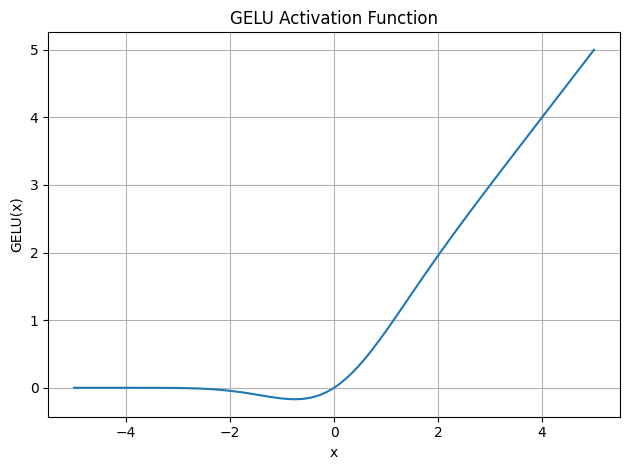

In [12]:
# plot GELU
import matplotlib.pyplot as plt

gelu = GELU()
x = torch.linspace(-5, 5, 100)
plt.plot(x, gelu(x))
plt.title("GELU Activation Function")
plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
# FFN module
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"],       # 768
                  4 * config["emb_dim"]),  # 3072
        GELU(),                            # 3072
        nn.Linear(4 * config["emb_dim"],   # 3072
                  config["emb_dim"])       # 768
        )

  def forward(self, x):
    return self.layers(x)

In [14]:
# create an instance
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(3, 5, 768)
output = ffn(x)
output.shape

torch.Size([3, 5, 768])

# Add Skip Connections

Let's make an example nn to show how skip connection affect learning ability of a model:

In [15]:
class ExampleDeepNN(nn.Module):
  def __init__(self, layer_sizes_list, use_skip_connection):
    super().__init__()
    self.use_skip_connection = use_skip_connection
    self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      # Compute the output of the current layer
      layer_output = layer(x)
      # Check if skip_connection can be applied
      if self.use_skip_connection and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x


def print_gradients(model, x):
    # forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # calculate loss
    loss = nn.MSELoss()
    loss = loss(output, target)

    # calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [16]:
# example setup
layer_sizes = [4, 4, 4, 4, 4, 1]
sample_input = torch.tensor([[1., 0., -1., 1]])

In [17]:
# without skip connection
torch.manual_seed(211)
model_wo_skip_connection = ExampleDeepNN(
    layer_sizes, use_skip_connection=False
)
print_gradients(model_wo_skip_connection, sample_input)

layers.0.0.weight has gradient mean of 0.0001875293382909149
layers.1.0.weight has gradient mean of 0.00015768714365549386
layers.2.0.weight has gradient mean of 0.0004450336564332247
layers.3.0.weight has gradient mean of 0.0012923781760036945
layers.4.0.weight has gradient mean of 0.01807313971221447


In [18]:
# with skip connection
torch.manual_seed(211)
model_w_skip_connection = ExampleDeepNN(
    layer_sizes, use_skip_connection=True
)
print_gradients(model_w_skip_connection, sample_input)

layers.0.0.weight has gradient mean of 0.6975078582763672
layers.1.0.weight has gradient mean of 0.6017700433731079
layers.2.0.weight has gradient mean of 0.6710034012794495
layers.3.0.weight has gradient mean of 0.4883677363395691
layers.4.0.weight has gradient mean of 4.474058151245117


# Implement Transformer Block

In [19]:
# from google.colab import files
# uploaded = files.upload()

In [20]:
import os, sys, pprint
print("CWD =", os.getcwd())          # <-- very likely .../exp_notebooks
print("models exists? ", os.path.isdir("../models"))
pprint.pp(sys.path[:5])              # first few search paths

CWD = C:\Users\user\Desktop\llm_project\exp_notebooks
models exists?  True
['C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python312',
 'C:\\Users\\user\\Desktop\\llm_project\\.venv']


In [21]:
import sys, pathlib, os

# one directory up from the notebook’s location
project_root = pathlib.Path(os.getcwd()).resolve().parent

# add it to sys.path if it isn’t already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Added →", project_root)

Added → C:\Users\user\Desktop\llm_project


In [22]:
from models.layers.attentions import MultiHeadAttention

class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                        output_embedding_dim=config["emb_dim"],
                                        context_length=config["context_length"],
                                        dropout=config["drop_rate"],
                                        num_heads=config["n_heads"],
                                        qkv_bias=config["qkv_bias"])
    self.feed_forward = FeedForward(config)
    self.layer_norm1 = LayerNorm(config["emb_dim"])
    self.layer_norm2 = LayerNorm(config["emb_dim"])
    self.drop_skip = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    # skip connection for attention block
    shortcut = x
    x = self.layer_norm1(x)
    x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
    x = self.drop_skip(x)
    x = shortcut + x # skip connection

    # skip connection for feed forward block
    shortcut = x
    x = self.layer_norm2(x)
    x = self.feed_forward(x)
    x = self.drop_skip(x)
    x = shortcut + x # skip connection

    return x

In [23]:
# create an instance
torch.manual_seed(211)
x = torch.rand(3, 5, 768) # shape: [batch_size, num_tokens, emb_size]
transformer_block = TransformerBlock(GPT_CONFIG_124M)
output = transformer_block(x)

print("input shape: ", x.shape)
print("output shape: ", output.shape)

input shape:  torch.Size([3, 5, 768])
output shape:  torch.Size([3, 5, 768])


# Implement The GPT2 Model

In [24]:
class GPT2Model(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.token_emb = nn.Embedding(config["vocab_size"],
                                  config["emb_dim"])
    self.position_emb = nn.Embedding(config["context_length"],
                                     config["emb_dim"])
    self.drop_emb = nn.Dropout(config["drop_rate"])

    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])])

    self.final_norm = LayerNorm(config["emb_dim"])

    self.out_head = nn.Linear(config["emb_dim"],
                              config["vocab_size"],
                              bias=False)

  def forward(self, input_token):
    batch_size, sequence_length = input_token.shape
    token_embeds = self.token_emb(input_token)
    position_embeds = self.position_emb(
        torch.arange(sequence_length,
                     device=input_token.device))
    embeds = token_embeds + position_embeds
    x = self.drop_emb(embeds)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [25]:
# create an instance
torch.manual_seed(211)
model = GPT2Model(GPT_CONFIG_124M)

logits = model(batch)
print("input batch: \n", batch)
print("output shape: ", logits.shape)
logits

input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
output shape:  torch.Size([2, 4, 50257])


tensor([[[-0.1072,  0.1188,  0.1927,  ..., -0.5764,  0.1074,  0.6490],
         [-0.2752,  0.1129, -0.6717,  ..., -0.2857,  0.4062, -0.5701],
         [-0.1557, -0.5613, -0.9250,  ..., -0.0414, -0.1987, -0.0625],
         [ 0.2493, -0.1712, -0.8216,  ..., -0.2317,  1.1078,  0.5068]],

        [[ 0.0198,  0.7883, -0.3144,  ..., -0.5261,  0.1450,  0.2379],
         [-0.1052,  0.3466, -1.0477,  ...,  0.0095,  0.6028,  0.4315],
         [-0.8114,  0.0372, -0.5859,  ...,  0.1969,  0.3706, -0.9927],
         [ 0.1452, -0.5805, -1.3235,  ..., -0.2818,  0.9731,  0.1584]]],
       grad_fn=<UnsafeViewBackward0>)

Let's explore the model:

In [26]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
    #print(f"{name}:\n{param}\n")

token_emb.weight: torch.Size([50257, 768])
position_emb.weight: torch.Size([1024, 768])
transformer_blocks.0.attention.W_query.weight: torch.Size([768, 768])
transformer_blocks.0.attention.W_key.weight: torch.Size([768, 768])
transformer_blocks.0.attention.W_value.weight: torch.Size([768, 768])
transformer_blocks.0.attention.output_projection.weight: torch.Size([768, 768])
transformer_blocks.0.attention.output_projection.bias: torch.Size([768])
transformer_blocks.0.feed_forward.layers.0.weight: torch.Size([3072, 768])
transformer_blocks.0.feed_forward.layers.0.bias: torch.Size([3072])
transformer_blocks.0.feed_forward.layers.2.weight: torch.Size([768, 3072])
transformer_blocks.0.feed_forward.layers.2.bias: torch.Size([768])
transformer_blocks.0.layer_norm1.scale: torch.Size([768])
transformer_blocks.0.layer_norm1.shift: torch.Size([768])
transformer_blocks.0.layer_norm2.scale: torch.Size([768])
transformer_blocks.0.layer_norm2.shift: torch.Size([768])
transformer_blocks.1.attention.W_q

In [27]:
# compute total number of params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters()
                        if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {trainable_params}")

Total number of parameters: 163009536
Total number of trainable parameters: 163009536


In [28]:
# can retrieve weights and layer names with state_dict()
for name, weights in model.state_dict().items():
    print(f"{name} → {weights.shape}")

token_emb.weight → torch.Size([50257, 768])
position_emb.weight → torch.Size([1024, 768])
transformer_blocks.0.attention.mask → torch.Size([1024, 1024])
transformer_blocks.0.attention.W_query.weight → torch.Size([768, 768])
transformer_blocks.0.attention.W_key.weight → torch.Size([768, 768])
transformer_blocks.0.attention.W_value.weight → torch.Size([768, 768])
transformer_blocks.0.attention.output_projection.weight → torch.Size([768, 768])
transformer_blocks.0.attention.output_projection.bias → torch.Size([768])
transformer_blocks.0.feed_forward.layers.0.weight → torch.Size([3072, 768])
transformer_blocks.0.feed_forward.layers.0.bias → torch.Size([3072])
transformer_blocks.0.feed_forward.layers.2.weight → torch.Size([768, 3072])
transformer_blocks.0.feed_forward.layers.2.bias → torch.Size([768])
transformer_blocks.0.layer_norm1.scale → torch.Size([768])
transformer_blocks.0.layer_norm1.shift → torch.Size([768])
transformer_blocks.0.layer_norm2.scale → torch.Size([768])
transformer_blo

later we will use `weight tying`:

In [29]:
# weight tying
print("token embedding layer shape: ", model.token_emb.weight.shape)
print("output embedding layer shape: ", model.out_head.weight.shape)

token embedding layer shape:  torch.Size([50257, 768])
output embedding layer shape:  torch.Size([50257, 768])


In [30]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)

print(f"Total number of parameters in GPT-2: {total_params_gpt2}")

Total number of parameters in GPT-2: 124412160


Let's compute the memory requirements:

In [31]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of GPT-2 in MB: {total_size_mb:.2f} MB")

Total size of GPT-2 in MB: 621.83 MB


# Generate Text

In [32]:
def generate_text_simple(model,
                         input_batch, # [batch, num_tokens]
                         max_new_tokens, # numbers of new tokens to be predicted
                         context_size):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
    probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
    predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True) # (batch, 1)
    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=-1) # [batch, num_tokens+1]

  return input_batch

In [33]:
# example setup
start_context = "Hi, my name is"
encoded = bpe_tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded tensor: \n", encoded_tensor)
print("encoded tensor shape: ", encoded_tensor.shape)

encoded:  [17250, 11, 616, 1438, 318]
encoded tensor: 
 tensor([[17250,    11,   616,  1438,   318]])
encoded tensor shape:  torch.Size([1, 5])


Since, we now don't have to train, let's put the model in `.eval()` mode:

In [34]:
model.eval()
output = generate_text_simple(
    model=model,
    input_batch=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("output length: ", output.shape[1])
print("output: \n", output)

output length:  15
output: 
 tensor([[17250,    11,   616,  1438,   318,  9758, 42360, 37069, 27391, 36602,
         13152, 33906, 36790, 22446, 42465]])


In [35]:
decoded_text = bpe_tokenizer.decode(output.squeeze().tolist())
print(decoded_text)

Hi, my name is constitutionaliageplet Gent stricterMediaVaMetal(). recurrent


In [36]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 0 min 7.67 sec
